# Buffering Observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from river import naive_bayes
from river import stream
from river.metrics import Accuracy, Rolling
from river.drift import ADWIN
from streamselect.concept_representations import ErrorRateRepresentation
from streamselect.states import State
from streamselect.repository import Repository, AbsoluteValueComparer
from streamselect.adaptive_learning import BaseAdaptiveLearner, BaseBufferedAdaptiveLearner, get_constant_max_buffer_scheduler, get_increasing_buffer_scheduler

Let us consider a data set featuring concept drift.

Text(0, 0.5, 'x')

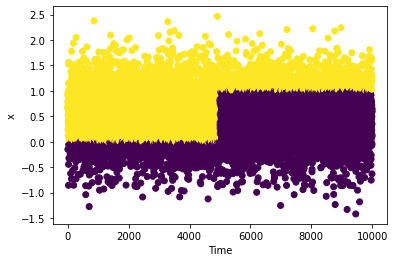

In [2]:
rng = np.random.default_rng(seed=1)
X = rng.normal(0.5, 0.5, 10000)
T = np.linspace(0, 10000, 10000)
Y = X > (0.0)
concept_drift_t = 5000
Y[concept_drift_t:] = X[concept_drift_t:] > (1.0)
plt.scatter(T, X, c=Y)
plt.xlabel("Time")
plt.ylabel("x")

In this univariate data set, the task is to predict a class y from the labels {0, 1} determined by some threshold on x.
Halfway through the dataset, the threshold changes, so observations which would be labelled as 1 are now labelled as 1.
This is an example of concept drift.

In the example shown in the `detecting_concept_drift.ipynb' file, we adapt to this concept drift using an adaptive learning system, which detects the change and constructs a new classifier to handle the new distribution of data.

0.9851425276708818 0.9702855798900827
0.9851425276708818 0.9702855798900827
0.22548231468001845 0.8921689942773382
0.22548231468001845 0.8921689942773382
0.9718657602658577 0.8969208251775495
0.9718657602658577 0.8969208251775495
0.9497861228261812 0.9437712122211708
0.9497861228261812 0.9437712122211708
0.9987367843318848 0.9706869351606064
0.9987367843318848 0.9706869351606064
Overall average accuracy was: 0.9722441416977828


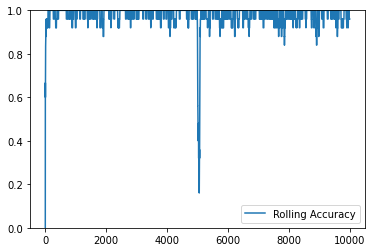

In [3]:
# Set some parameters for out system
window_size = 25
update_period = 1

classifier: BaseAdaptiveLearner = BaseAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower"
)

accuracy = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations = []

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    observations.append(classifier.performance_monitor.last_trained_observation)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

However, lets inspect which observations were classified by each state

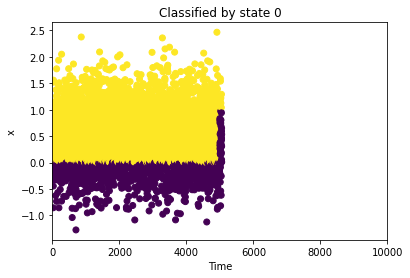

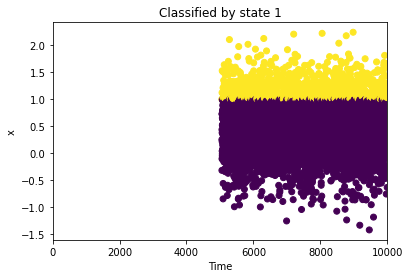

In [4]:
state_ids = list(classifier.repository.states)
for s_id in state_ids:
    ob_X = [ob.x[list(ob.x)[0]] for ob in observations if ob is not None and ob.active_state_id == s_id]
    ob_T = [ob.seen_at for ob in observations if ob is not None and ob.active_state_id == s_id]
    ob_y = [ob.y for ob in observations if ob is not None and ob.active_state_id == s_id]
    plt.scatter(ob_T, ob_X, c=ob_y)
    plt.xlim([0, 10000])
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.title(f"Classified by state {s_id}")
    plt.show()

We observe that while the adaptive learning system was able to roughly split the data into the two concepts, however there is a short period where state 0 is classifying and learning from observations drawn from the following concept. This overlap period is inevitable, because there will always be some delay in detecting concept drift. This period harms performance in two ways:
- We are classifying observations with a state representing the wrong concept.
- We are training a state with observations from a different concept.

While we can't avoid classifying with the wrong state, it is out best guess, we *can* avoid training state on these wrong observations by introducing some delay.

The basic idea is that we add observations to a *buffer*, which releases observations after some delay. If we do not detect a concept drift while an observation is buffered, we can assume it correctly represents the current state and we can learn from it.

We can use the BaseBufferedAdaptiveLearner to utilize a buffer. First, we show that it behaves identically with a buffer which delays observations by 0 timeteps, the default.

0.9851425276708818 0.9702855798900827
0.9851425276708818 0.9702855798900827
0.22548231468001845 0.8921689942773382
0.22548231468001845 0.8921689942773382
0.9718657602658577 0.8969208251775495
0.9718657602658577 0.8969208251775495
0.9497861228261812 0.9437712122211708
0.9497861228261812 0.9437712122211708
0.9987367843318848 0.9706869351606064
0.9987367843318848 0.9706869351606064
Overall average accuracy was: 0.9722441416977828


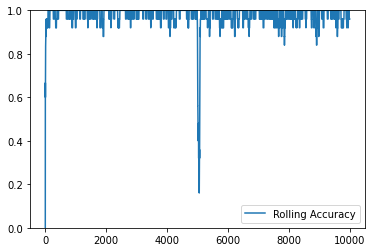

In [5]:
# Set some parameters for out system
window_size = 25
update_period = 1

classifier: BaseAdaptiveLearner = BaseBufferedAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower",
    buffer_timeout_max=0.0,
)

accuracy = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations_buffered = []

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    observations_buffered.append(classifier.performance_monitor.last_trained_observation)
    # Since we haven't set a buffer_timeout, the buffered system should behave identically.
    assert observations_buffered[t].active_state_id == observations[t].active_state_id
    assert observations_buffered[t].predictions[observations_buffered[t].active_state_id] == observations[t].predictions[observations[t].active_state_id]

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

Now we test with a longer buffer_timeout

0.8921893149763728 0.8793862985774888
0.9851425276708818 0.9702855798900827
0.9755075070625769 0.9692793677684978
0.2195558077123031 0.8327857148923982
0.22548231468001845 0.8921689942773382
0.8393189017018148 0.47124597847148547
0.8772366044884432 0.643264252958426
0.9360085830549164 0.8281721348515534
0.9718657602658577 0.8969208251775495
0.939203523569913 0.926371178575349
0.9497861228261812 0.9437712122211708
0.9619483902127962 0.9649191630821147
0.880704992685674 0.4827991195882424
0.9266520913474355 0.8356841563427385
0.9578610533732071 0.9509783059582937
0.9938397732591936 0.9458430329884675
0.9705987615169467 0.9694997210469893
0.9925639870610407 0.9730278573640935
Overall average accuracy was: 0.941836


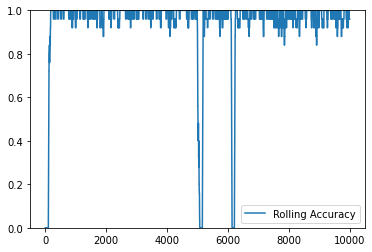

In [6]:
# Set some parameters for out system
window_size = 25
update_period = 1
# We will test setting the buffer_timeout to 25, i.e., delay learning from observations for 25
# timesteps.
buffer_timeout_max = 100

classifier: BaseAdaptiveLearner = BaseBufferedAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower",
    buffer_timeout_max=buffer_timeout_max,
    buffer_timeout_scheduler=get_constant_max_buffer_scheduler()
)

accuracy = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations_buffered = []

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    observations_buffered.append(classifier.performance_monitor.last_trained_observation)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

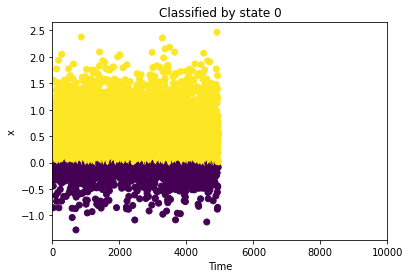

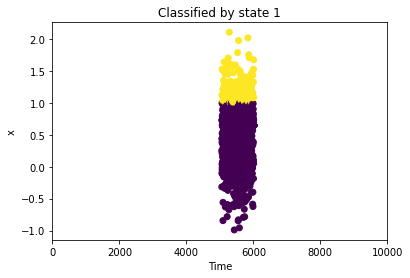

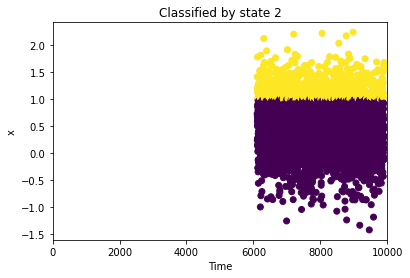

In [7]:
state_ids = list(classifier.repository.states)
for s_id in state_ids:
    ob_X = [ob.x[list(ob.x)[0]] for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_T = [ob.seen_at for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_y = [ob.y for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    plt.scatter(ob_T, ob_X, c=ob_y)
    plt.xlim([0, 10000])
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.title(f"Classified by state {s_id}")
    plt.show()

The buffer seems correctly only trained states on observations from a single concept, but it also seems to have made performance worse! Why is this?

Well, the buffer delays training on new observations by buffer_timeout. This means with a buffer_timeout of 500 observations, we cannot even start learning until 500 observations have been predicted.

There seems to be some risk/reward tradeoff. The risk of training on a new observation is that we may introduce errors by training on an observation from a different concept. The reward is that we may improve performance be training on an observation from the same concept.
How can we incorporate this into our buffer_timeout?

We note that at the start of a classifiers life, it's possible reward is very high as a new observation may improve accuracy substantially. As it trains, the possible reward gets lower as the classifier converges to some maximum performance. On the otherhand, risk is relatively stationary (we could look at other ways of measuring risk on a per observation level, this is future work as per my thesis!). This means we could schedule buffer_timeout to account for this changing tradeoff by increasing over time.

In the example below, we schedule buffer_timeout to be the amount of training weight seen by the active state, up to some maximum.

0.892189314976373 0.5816393595066621
0.9180759433695671 0.7321791854901837
0.9235988267809379 0.8830790318263426
0.9851425276708818 0.9702855798900827
0.9754468808610293 0.9681314230813278
0.21955580771230299 0.8327857148923958
0.22548231468001845 0.8921689942773382
0.9718657602658577 0.8969208251775495
0.9497861228261812 0.9437712122211708
0.9439255799916672 0.9100048516922588
0.9893641574717791 0.9378146727311026
0.9994102621017881 0.9671106318412277
0.9987367843318848 0.9706869351606064
Overall average accuracy was: 0.9626441416977827


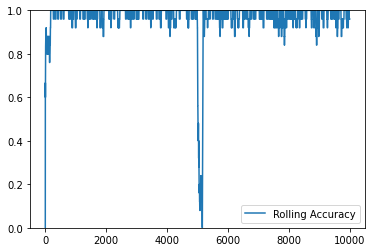

In [8]:
# Set some parameters for out system
window_size = 25
update_period = 1
# We will test setting the maximum buffer_timout
buffer_timeout_max = 100

classifier: BaseAdaptiveLearner = BaseBufferedAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower",
    buffer_timeout_max=buffer_timeout_max,
    buffer_timeout_scheduler=get_increasing_buffer_scheduler(1.0)
)

accuracy = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations_buffered = []

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    # The buffer scheduling using get_increasing_buffer_scheduler is equivalent to calling:
    # classifier.buffer_timeout = min(classifier.get_active_state().seen_weight, buffer_timeout_max)
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    observations_buffered.append(classifier.performance_monitor.last_trained_observation)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

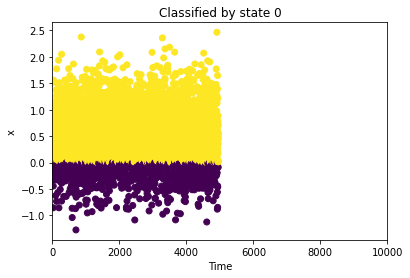

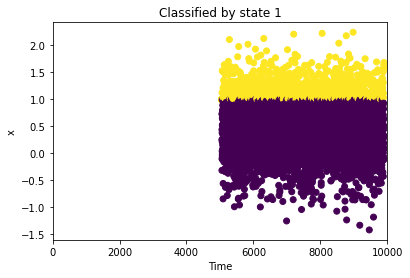

In [9]:
state_ids = list(classifier.repository.states)
for s_id in state_ids:
    ob_X = [ob.x[list(ob.x)[0]] for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_T = [ob.seen_at for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_y = [ob.y for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    plt.scatter(ob_T, ob_X, c=ob_y)
    plt.xlim([0, 10000])
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.title(f"Classified by state {s_id}")
    plt.show()

Accuracy is slightly lower, because we are delaying training slightly, but we observe that we are training observations on cleaner representations of their respective concepts. This is important when we want to reuse a state in the future.

0.9764201156907317 0.971587027580255
0.9764201156907317 0.971587027580255
0.22548231468001845 0.9552736875051382
0.22548231468001845 0.9552736875051382
0.9874494173137657 0.9337392743956769
0.9874494173137657 0.9337392743956769
0.9945641631521456 0.9714247356499801
0.9945641631521456 0.9714247356499801
0.31514877024107235 0.9519097154480728
0.31514877024107235 0.9519097154480728
0.9787958361533605 0.9733316781325378
0.3071387483156919 0.7822764966652351
0.306749335889378 0.7760137189315102
[None, D(DriftType.DriftDetectorTriggered@5055-{0: 0.22548231468001845, -1: 0.22548231468001845}|0->1), D(DriftType.DriftDetectorTriggered@10047-{0: 0.9745176853199814, 1: 0.31514877024107235, -1: 0.31514877024107235}|1->0), D(DriftType.DriftDetectorTriggered@15071-{0: 0.3071387483156919, 1: 0.9951487702410723, -1: 0.306749335889378}|0->1)]
Overall average accuracy was: 0.9719220708488914


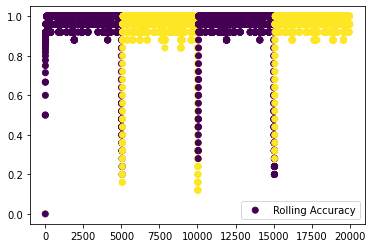

In [10]:
from itertools import chain


# Set some parameters for out system
window_size = 25
update_period = 1

classifier = BaseAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=lambda : ADWIN(1e-4),
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower"
)

accuracy = []
error_rate = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations_buffered = []
active_state_relevance = []
active_rep_val = []
buffered_rep_val = []
drifts = [None]

timesteps = []
active_state_id = []
for t, (x, y) in enumerate(chain(stream.iter_array(X.reshape(-1, 1), Y), stream.iter_array(X.reshape(-1, 1), Y))):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    timesteps.append(t)
    active_state_id.append(classifier.active_state_id)
    observations_buffered.append(classifier.performance_monitor.last_trained_observation)
    active_state_relevance.append(classifier.performance_monitor.active_state_relevance)
    if classifier.performance_monitor.last_drift != drifts[-1]:
        drifts.append(classifier.performance_monitor.last_drift)
    try:
        active_rep_val.append(classifier.active_window_state_representations[0].meta_feature_values[0])
        buffered_rep_val.append(classifier.repository.states[0].get_self_representation().meta_feature_values[0])
    except:
        pass

print(drifts)
print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.scatter(timesteps, accuracy, c = active_state_id, label="Rolling Accuracy")
plt.legend()
plt.show()

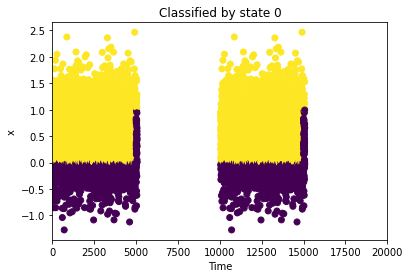

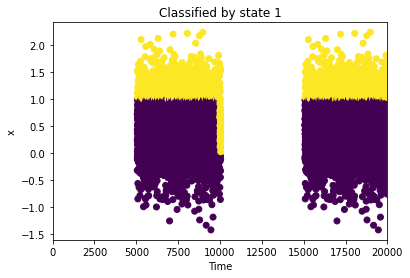

In [11]:
state_ids = list(classifier.repository.states)
for s_id in state_ids:
    ob_X = [ob.x[list(ob.x)[0]] for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_T = [ob.seen_at for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_y = [ob.y for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    plt.scatter(ob_T, ob_X, c=ob_y)
    plt.xlim([0, 20000])
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.title(f"Classified by state {s_id}")
    plt.show()

(-100.0, 5500.0)

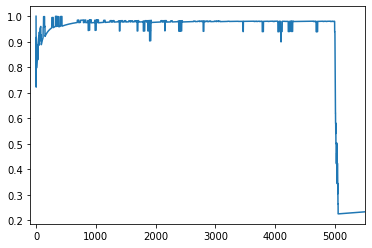

In [12]:
ts = [t for t,a_id in enumerate(active_state_id) if a_id == 0]
rel = [x for t,x in enumerate(active_state_relevance) if t in ts]
plt.plot(ts, rel)
plt.xlim([-100, 5500])

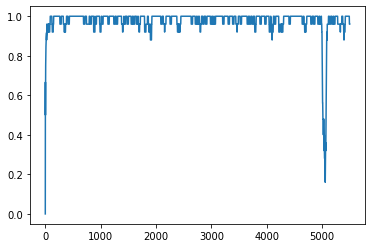

In [13]:
plt.plot(accuracy[:5500])

(0.0, 1.0)

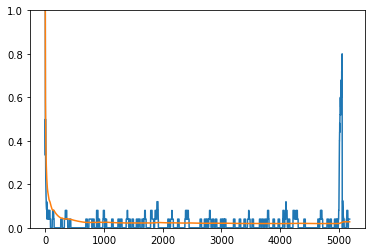

In [14]:
plt.plot(active_rep_val[:5183])
plt.plot(buffered_rep_val[:5183])
plt.ylim([0, 1])

0.9764201156907317 0.971587027580255
0.9774684578903671 0.9754063401158156
0.21963432704721408 0.9670071649215471
0.22548231468001845 0.9552736875051382
0.9820985938761078 0.9289406739398717
0.9874494173137657 0.9337392743956769
0.9999192207829319 0.9654368621164463
0.9945641631521456 0.9714247356499801
0.3095104049305335 0.9638309911504138
0.31514877024107235 0.9519097154480728
0.9787958361533605 0.9733316781325378
0.26178434874342127 0.7752474825198878
0.306749335889378 0.7760137189315102
Overall average accuracy was: 0.9688220708488914
[None, D(DriftType.DriftDetectorTriggered@5055-{0: 0.21963432704721408, -1: 0.22548231468001845}|0->1), D(DriftType.DriftDetectorTriggered@10047-{0: 0.9803656729527858, 1: 0.3095104049305335, -1: 0.31514877024107235}|1->0), D(DriftType.DriftDetectorTriggered@15071-{0: 0.26178434874342127, 1: 0.9895104049305334, -1: 0.306749335889378}|0->1)]


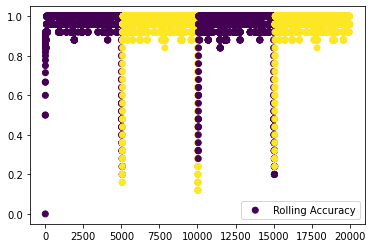

In [15]:
from itertools import chain


# Set some parameters for out system
window_size = 25
update_period = 1
# We will test setting the maximum buffer_timout
buffer_timeout_max = 75

classifier = BaseBufferedAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=lambda : ADWIN(1e-4),
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower",
    buffer_timeout_max=buffer_timeout_max,
    buffer_timeout_scheduler=get_increasing_buffer_scheduler(0.11)
)

accuracy = []
error_rate = []
acc_metric = Rolling(metric=Accuracy(), window_size=window_size)
observations_buffered = []
active_state_relevance = []
active_rep_val = []
buffered_rep_val = []
drifts = [None]

timesteps = []
active_state_id = []
for t, (x, y) in enumerate(chain(stream.iter_array(X.reshape(-1, 1), Y), stream.iter_array(X.reshape(-1, 1), Y))):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    timesteps.append(t)
    active_state_id.append(classifier.active_state_id)
    observations_buffered.append(classifier.performance_monitor.last_trained_observation)
    active_state_relevance.append(classifier.performance_monitor.active_state_relevance)
    if classifier.performance_monitor.last_drift != drifts[-1]:
        drifts.append(classifier.performance_monitor.last_drift)
    try:
        active_rep_val.append(classifier.active_window_state_representations[0].meta_feature_values[0])
        buffered_rep_val.append(classifier.repository.states[0].get_self_representation().meta_feature_values[0])
    except:
        pass

print(f"Overall average accuracy was: {np.mean(accuracy)}")
print(drifts)
plt.scatter(timesteps, accuracy, c = active_state_id, label="Rolling Accuracy")
plt.legend()
plt.show()

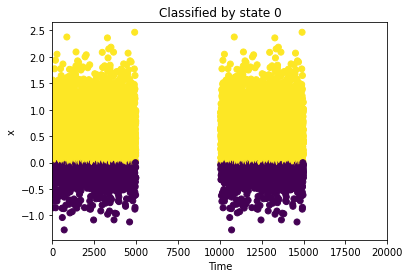

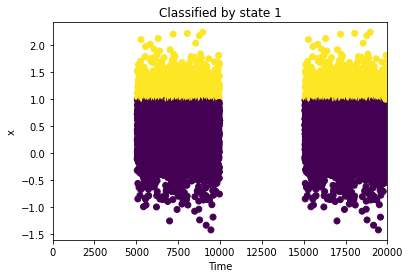

In [16]:
state_ids = list(classifier.repository.states)
for s_id in state_ids:
    ob_X = [ob.x[list(ob.x)[0]] for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_T = [ob.seen_at for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    ob_y = [ob.y for ob in observations_buffered if ob is not None and ob.active_state_id == s_id]
    plt.scatter(ob_T, ob_X, c=ob_y)
    plt.xlim([0, 20000])
    plt.xlabel("Time")
    plt.ylabel("x")
    plt.title(f"Classified by state {s_id}")
    plt.show()

(-100.0, 5500.0)

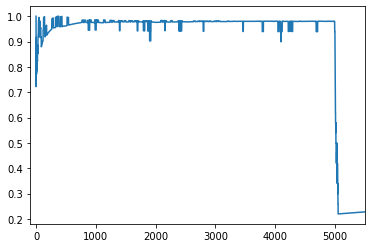

In [17]:
ts = [t for t,a_id in enumerate(active_state_id) if a_id == 0]
rel = [x for t,x in enumerate(active_state_relevance) if t in ts]
plt.plot(ts, rel)
plt.xlim([-100, 5500])

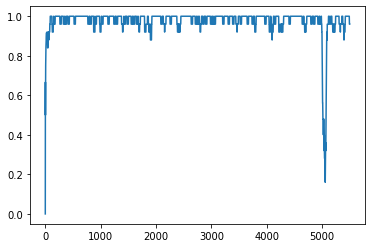

In [18]:
plt.plot(accuracy[:5500])

(0.0, 1.0)

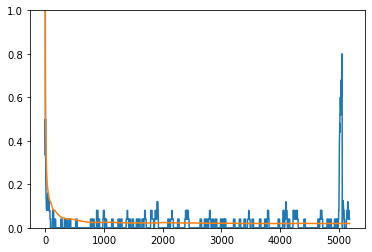

In [19]:
plt.plot(active_rep_val[:5183])
plt.plot(buffered_rep_val[:5183])
plt.ylim([0, 1])